In [3]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import os
from sklearn.neighbors import NearestNeighbors
from PIL import Image

In [ ]:
## Features_dir Sturucture

Features_dir
    --slide1
        --cells
            --Basophils
            --Blast
            ...
            --Promyelocyte
        all_deep_features.pkl
    --slide2
    --slide3


In [4]:
#define the directory, it will be stored accordingly if t
features_dir = "..."

WSI        name  \
0    18_0004_AS  18_0004_AS   
1    18_0007_AS  18_0007_AS   
2    18_0009_AS  18_0009_AS   
3    18_0010_AS  18_0010_AS   
4    18_0014_AS  18_0014_AS   
..          ...         ...   
256  19_0696_AS  19_0696_AS   
257  19_0701_AS  19_0701_AS   
258  19_0702_AS  19_0702_AS   
259  19_0709_AS  19_0709_AS   
260  19_0712_AS  19_0712_AS   

                                                result      type  patient  \
0    {"PARTICLES": "HYPERCELLULAR.", "MEGAKARYOCYTE...  aspirate      699   
1    {"PARTICLES": "HYPERCELLULAR FOR AGE.", "MEGAK...  aspirate      110   
2    {"PARTICLES": "NORMAL", "MEGAKARYOCYTES AND PL...  aspirate       51   
3    {"PARTICLES": "HYPERCELLULAR.", "MEGAKARYOCYTE...  aspirate      180   
4    {"PARTICLES": "CELLULAR.", "MEGAKARYOCYTES AND...  aspirate      251   
..                                                 ...       ...      ...   
256  {"PARTICLES": "HYPERCELLULAR.", "MEGAKARYOCYTE...  aspirate      585   
257  {"PARTICLES": "HYPERCELLULAR FOR AGE.", "MEGAK...  aspirate      740   
258  {"PARTICLES": "MARKEDLY INCREASED.", "MEGAKARY...  aspirate      173   
259  {"PARTICLES": "HYPERCELLULAR FOR AGE.", "MEGAK...  aspirate      443   
260  {"PARTICLES": "HYPERCELLULAR.", "MEGAKARYOCYTE...  aspirate      580   

                                                  tags  
0                                               normal  
1              hypercellular; myelodysplastic syndrome  
2                                               normal  
3                 erythroid hyperplasia; hypercellular  
4     acute myeloid leukemia; myelodysplastic syndrome  
..                                                 ...  
256                                             normal  
257               erythroid hyperplasia; hypercellular  
258  basophilia; chronic myeloid leukemia; eosinoph...  
259                                             normal  
260  acute myeloid leukemia; acute promyelocytic le...  

[261 rows x 6 columns]

In [5]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import plotly.express as px
import umap
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def cellplot(slide_id, targets, sample_size = 400, r1 = 600, r2 = 600 , save = False):
    df_file = os.path.join(features_dir, slide_id, "all_deep_features.pkl")
    df_slide = pd.read_pickle(df_file)
    
    #remove irrelevant objects 
    df_slide = df_slide[~df_slide.cell_type.isin(irrelevant_objects)].reset_index(drop=True)
    
    
    #create a UMAP for target cells
    df_target = df_slide[df_slide.cell_type.isin(targets)].reset_index(drop=True)

    
    reducer = umap.UMAP(n_neighbors = 10, min_dist=0.8)
    x = np.array(df_target.iloc[:,3:])
    x_scaled = StandardScaler().fit_transform(x)
    embedding = reducer.fit_transform(x_scaled)
    df_umap_viz = pd.DataFrame(embedding, columns=["UMAP 1", "UMAP 2"])
    df_umap_viz["cell_type"] = df_target.cell_type.reset_index(drop=True)
    
    
    #sampling cells and reading detected bounding boxes
    indices = np.random.randint(0,df_target.shape[0], sample_size)
    df_viz = df_target.loc[indices].reset_index(drop = True)
    df_umap_vizcell = df_umap_viz.loc[indices].reset_index(drop = True)

    images = []
    for i in range(df_viz.shape[0]):
        target = df_viz.loc[i].cell_type
        file = df_viz.loc[i].image_file[:-4] + "_" + str(df_viz.loc[i].cell_index) + ".jpg"

        image = cv2.imread(os.path.join(features_dir, slide_id, "cells", target, file))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        images.append(image)
        
    #creating the cellplot   
    fig, ax = plt.subplots(figsize=(60,60))

    sns.scatterplot(data = df_umap_vizcell, x = "UMAP 1", y = "UMAP 2", hue = "cell_type",
                    hue_order = targets, palette = "tab20")
    
    ax.set_aspect("equal")
    plt.xticks(fontsize = 40)
    plt.yticks(fontsize = 40)
    plt.xlabel("UMAP 1", fontsize = 40)
    plt.ylabel("UMAP 2", fontsize = 40)
    
    ax.legend(markerscale = 5, fontsize = 40)
    
    


    for x0, y0, patch, cell_type in zip(df_umap_vizcell.iloc[:,0], df_umap_vizcell.iloc[:,1], images, df_umap_vizcell.iloc[:,2]):
        # showing images at x0 and y0, you can adjust zoom 
        ab = AnnotationBbox(OffsetImage(patch, zoom = 1), (x0, y0), frameon=False)
        ax.add_artist(ab)

        w = patch.shape[1]
        h = patch.shape[0]

        plt.gca().add_patch(Rectangle((x0 - w/r1,y0 - h/r2), 2*w/r1, 2*h/r2,linewidth = 40,
                                      edgecolor= plt.cm.tab20.colors[targets.index(cell_type)], facecolor='none'))
        
    if save:
        fig.savefig(slide_id + ".pdf")

In [6]:
irrelevant_objects = ["Debris", "Platelet", "Platelet_clump", "Other_cell", "Megakaryocyte_nucleus"]

targets = ["Neutrophil", "Metamyelocyte", "Myelocyte", "Promyelocyte", "Blast", "Erythroblast",
                    "Lymphocyte", "Monocyte", "Plasma_cell", "Eosinophil", "Basophil"]

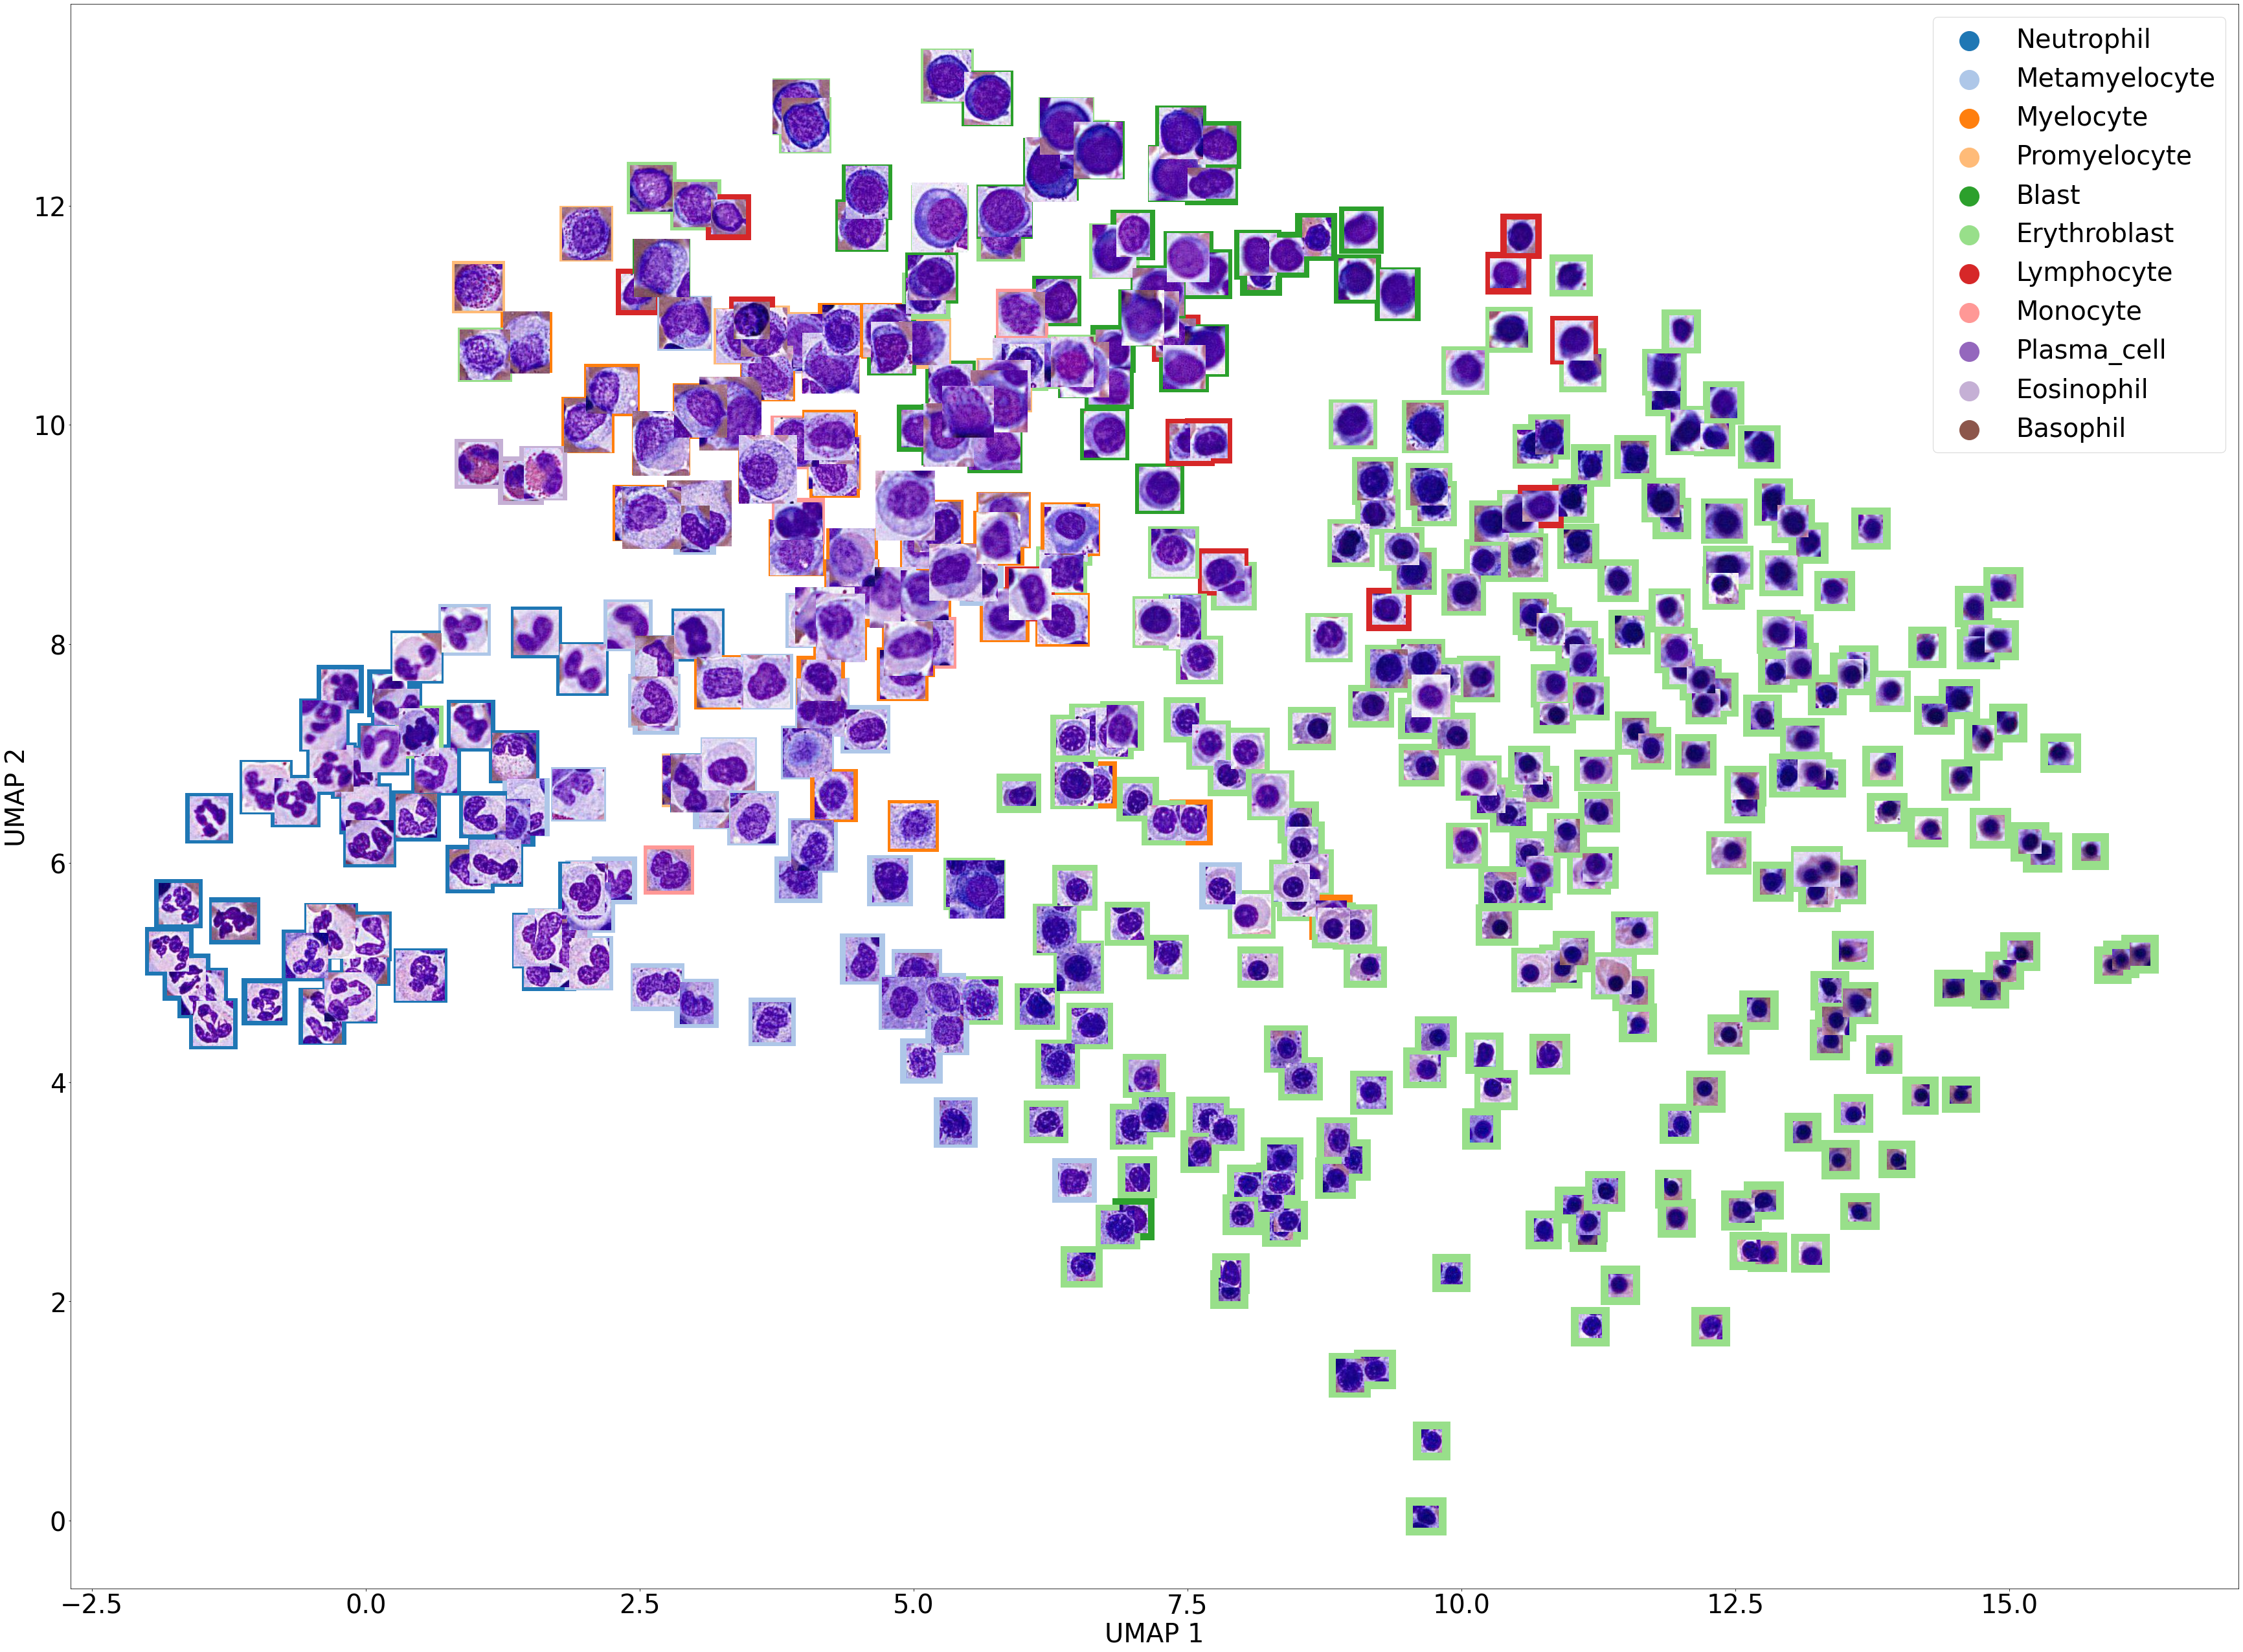

In [7]:
#define slide name
slide = "..."
cellplot(slide, targets, sample_size=500, save = False)